# Natural Language Processing Assignment 3: The Notebook

This is the notebook for the third and final hand-in assignment for Natural Language Processing. The notebook counts for 100% of the total assignment, the total assignment counts towards 20% of the final grade.

In this notebook, you will be using the Huggingface Transformers library to work with pretrained transformer-based language models. Our running task will be: Natural Language Inference.

The assignment broadly consists of three parts:

1. Data preparation: where you will learn about the task, and prepare the data to be consumed by your PyTorch model.
2. Model finetuning: where you finetune a `transformers` model on the task.
3. Multilingual comparison: where you will compare the results on the English dataset to results on its Dutch incarnation.
4. In-context learning: where you see how well a non-finetuned generative model like GPT-2 works on the same task.


### Note
When finetuning huggingface models, the models are saved to your computer. These files can be big (500MB-1GB), so do not hand them in! Instead, make sure that all cell outputs after running the code are visible (so: not cleared) when you hand in the assignment, this way we can see that you've done the training.


## Part 1 (14 points): Data preparation

In this part you will familiarize yourself with the task at hand: Natural Language Inference. Recall from the course lectures that Natural Language Inference is a three-way sequence classification task over two sentences. Given a premise and a hypothesis, the task is to decide whether the premise Entails, Contradicts, or is Neutral with respect to the hypothesis. We will work with the SICK (Sentences Involving Compositional Knowledge) dataset of (Marelli et al. 2014) and its Dutch incarnation (Wijnholds & Moortgat, 2021).

But first, we need to ensure that we have all the right packages installed, and then make some initial package imports, as usual. We assume that by now you have `torch` already installed.

In [1]:
# HuggingFace Transformers library ([torch] is used to get the correct version of accelerate)
!pip install transformers[torch]
# HuggingFace Datasets library
!pip install datasets
# HuggingFace Evaluate library
!pip install evaluate
# Scikit Learn, for evaluation metrics and confusion matrix
!pip install scikit-learn
# Seaborn, for nice plots
!pip install seaborn

# Install tf-keras
!pip install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
from datasets import load_dataset
import evaluate

### The SICK Dataset

The SICK dataset was introduced in 2014 as one of the first dataset to measure relatedness between full sentences, but additionally also is labelled with Natural Language Inference labels. The good news for us is that the Dutch version of SICK, the SICK-NL dataset, is actually on the HuggingFace Hub: ['maximedb/sick_nl'](https://huggingface.co/datasets/maximedb/sick_nl). You can go ahead and check out some samples through the link, or check out the code below; loading the data is now incredibly simple:

In [3]:
raw_datasets = load_dataset('maximedb/sick_nl')
display(raw_datasets['train'][0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

(…)-00000-of-00001-842ce0d8ae9292f7.parquet:   0%|          | 0.00/369k [00:00<?, ?B/s]

(…)-00000-of-00001-abd25633d85ce74e.parquet:   0%|          | 0.00/63.8k [00:00<?, ?B/s]

(…)-00000-of-00001-2a492d0fcdd5479c.parquet:   0%|          | 0.00/390k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4439 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/495 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4906 [00:00<?, ? examples/s]

{'pair_ID': 1,
 'sentence_A': 'Een groepje kinderen speelt in een tuin en een oude man staat op de achtergrond',
 'sentence_B': 'Een groep jongens in een tuin is aan het spelen en een man staat op de achtergrond',
 'entailment_label': 'NEUTRAL',
 'relatedness_score': 4.5,
 'entailment_AB': 'A_neutral_B',
 'entailment_BA': 'B_neutral_A',
 'sentence_A_original': 'A group of kids is playing in a yard and an old man is standing in the background',
 'sentence_B_original': 'A group of boys in a yard is playing and a man is standing in the background',
 'sentence_A_dataset': 'FLICKR',
 'sentence_B_dataset': 'FLICKR',
 'SemEval_set': 'TRAIN',
 'label': 1,
 'label_seq2seq': '2'}

Isn't that sick? The example above shows the structure of the data, containing Dutch and English premise (`sentence_A`) and hypothesis (`sentence_B`) sentences. You may notice that `entailment_label` and `label`; the latter is just the integer version of the actual label..

### Part 1.1 (6 points):

Check out some more examples of the train data, until you find out the correspondence between entailment labels and the integer versions of them. Prove it by finishing the implementation below:

In [4]:
label2id = {'Contradiction': 0, 'Neutral': 1, 'Entailment': 2}
id2label = {0: 'Contradiction', 1: 'Neutral', 2: 'Entailment'}

### Part 1.2 (8 points): Tokenization

Now, as we've seen in the lectures and in the HuggingFace NLP course, we need to prepare the raw data in a form that `transformers` models will understand. Again, unlike the previous hand-in assignment, preparing the data is very simple. The below code loads a tokenizer for a BERT base model (uncased), and creates a tokenized version of the data, and prepares a data collator, which we will need to use to wrap everything up properly during training.

The only missing part is the implementation of `tokenize_function` below. It takes in a data point (like the example printed above) and returns a tokenized model input, ready to pass to a BERT model. Finish its implementation, ensuring that it returns the correct tokenized input (refer to the slides if you need to recall how you tokenize a pair of sentences for BERT). You can run the test code underneath to verify your implementation.

In [5]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding

def tokenize_function(tokenizer, example):
    sentence_A = example['sentence_A']
    sentence_B = example['sentence_B']
    return tokenizer(sentence_A, sentence_B, truncation=True)

bert_name = 'bert-base-uncased'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_name)
tokenized_datasets = raw_datasets.map(lambda x: tokenize_function(bert_tokenizer, x), batched=True)
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4439 [00:00<?, ? examples/s]

Map:   0%|          | 0/495 [00:00<?, ? examples/s]

Map:   0%|          | 0/4906 [00:00<?, ? examples/s]

In [6]:
print('Input IDs:')
print(tokenized_datasets['train'][0]['input_ids'])
print('\nToken Type IDs:')
print(tokenized_datasets['train'][0]['token_type_ids'])
print('\nAttention Mask:')
print(tokenized_datasets['train'][0]['attention_mask'])

Input IDs:
[101, 25212, 2078, 24665, 8913, 2361, 6460, 2785, 7869, 2078, 11867, 4402, 7096, 1999, 25212, 2078, 10722, 2378, 4372, 25212, 2078, 15068, 3207, 2158, 2358, 11057, 2102, 6728, 2139, 9353, 11039, 2121, 16523, 15422, 102, 25212, 2078, 24665, 8913, 2361, 18528, 6132, 1999, 25212, 2078, 10722, 2378, 2003, 9779, 2078, 21770, 11867, 12260, 2078, 4372, 25212, 2078, 2158, 2358, 11057, 2102, 6728, 2139, 9353, 11039, 2121, 16523, 15422, 102]

Token Type IDs:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Attention Mask:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Part 2 (30 points): Finetuning BERT

So far so good. Now it's time to finetune a BERT model! Don't worry, the dataset was chosen to be small enough for you to finetune on your own machine (and on CPU), if you have 8GB+ of working memory available. Okay let's get to it.

### Part 2.1 (6 Points)

Given that we have the name of the BERT model we want to train, we need to load in a pretrained model. Finish the one-liner below to setup a model for three-way classification so you can finetune for Natural Language Inference:

In [7]:
from transformers import AutoModelForSequenceClassification

bert_model = AutoModelForSequenceClassification.from_pretrained(bert_name, num_labels=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wow, a one-liner to define a whole model! Let's continue with the model training..

### Part 2.2 (12 Points)

Let's get to training. Again, HuggingFace provides us with a lot of built-in functionality. The code below sets everything up: `compute_metrics` implements the method for calculating accuracy during training, using the `evaluate` library. Then, we have to set up a `Trainer` with a number of `TrainingArguments`. Finish the implementation so that we will run for 3 epochs, with a training batch size low enough for your machine (on the test machine, an M1 MacBook Air 2020 with 16GB working memory, a batch size of 16 was used). Check what device the implementation is going to use (CPU, CUDA, MPS?).

In [8]:
from transformers import TrainingArguments, Trainer

def compute_metrics(eval_preds):
    accuracy = evaluate.load("accuracy")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

# If you're running on an M1/M2 MacBook, with MPS backend support,
# you can replace "TrainingArguments" by "TrainingArgumentsWithMPSSupport"
# If not, just ignore this Python class!
class TrainingArgumentsWithMPSSupport(TrainingArguments):

    @property
    def device(self) -> torch.device:
        if torch.cuda.is_available():
            return torch.device("cuda")
        elif torch.backends.mps.is_available():
            return torch.device("mps")
        else:
            return torch.device("cpu")

training_args = TrainingArguments("my-trainer",
                                  per_device_train_batch_size=16,
                                  num_train_epochs=3,
                                  logging_strategy="epoch",
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  dataloader_num_workers=0,
                                  load_best_model_at_end=True,
                                  save_total_limit=2)

trainer = Trainer(
    bert_model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    tokenizer=bert_tokenizer,
    compute_metrics=compute_metrics
)
display(training_args.device)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-d632a5a70b3f>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


device(type='cpu')

Now, press the button on the cell below, and make some tea while you wait for the finetuning to finish :-)

In [9]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.715900,0.760061,0.690909
2,0.505100,0.530492,0.787879
3,0.337500,0.593439,0.800000


TrainOutput(global_step=834, training_loss=0.5194701233641993, metrics={'train_runtime': 9454.4829, 'train_samples_per_second': 1.409, 'train_steps_per_second': 0.088, 'total_flos': 452362882362804.0, 'train_loss': 0.5194701233641993, 'epoch': 3.0})

Finally, now use the `Trainer` (that already loaded the best performing checkpoint/epoch), to evaluate on the test set and display test accuracy. It should be above 80%.

In [10]:
# 2.2b Solution:
test_predictions = trainer.predict(tokenized_datasets['test'])
print('Test accuracy: ', test_predictions[2]['test_accuracy'])

Test accuracy:  0.8120668569099062


### Part 2.3 (12 Points)

Wasn't that incredibly easy? However, we would like to have a bit more insight in the model's predictions now. For this, we are going to look into precision, recall, and F1 score for the different classes.
First, complete the implementation below to retrieve, for the test set, the model's predicted labels and the correct labels. Then inspect the confusion matrix that comes out, and its pretty-printed heatmap version.
Finally, the precision, recall and f1 score are also printed. Use those to explain the confusion matrix: are the model's predictions at the rows and the correct answers at the columns or the other way around?

*If you're confused about what a confusion matrix is, check out [Scikit Learn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) or review the slides of Week 3 (the part on multiclass evaluation and micro/macro-averaging).*

array([[ 584,   92,   36],
       [ 107, 2423,  260],
       [  11,  416,  977]])

array([0.83190883, 0.82668031, 0.7674784 ])

array([0.82022472, 0.86845878, 0.69586895])

array([0.82602546, 0.84705471, 0.72992155])

array([ 712, 2790, 1404])

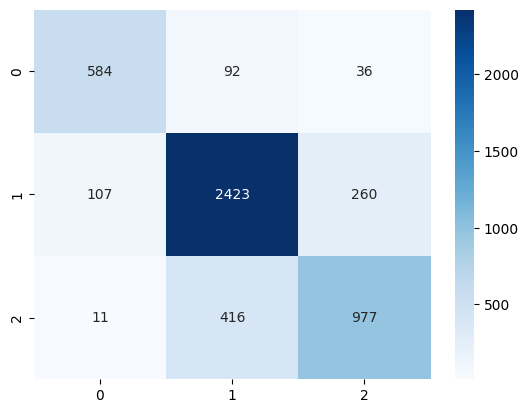

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

preds = np.argmax(test_predictions.predictions, axis=1)
trues = test_predictions.label_ids

cf_matrix = confusion_matrix(trues, preds)
display(cf_matrix)

sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

precision, recall, f1, support = precision_recall_fscore_support(trues, preds)
display(precision)
display(recall)
display(f1)
display(support)

## Part 3 (24 points): Multilingual comparison

Hey, this dataset you're using... it contains English and Dutch! In fact, let's revisit an example:

In [12]:
display(raw_datasets['train'][0])

{'pair_ID': 1,
 'sentence_A': 'Een groepje kinderen speelt in een tuin en een oude man staat op de achtergrond',
 'sentence_B': 'Een groep jongens in een tuin is aan het spelen en een man staat op de achtergrond',
 'entailment_label': 'NEUTRAL',
 'relatedness_score': 4.5,
 'entailment_AB': 'A_neutral_B',
 'entailment_BA': 'B_neutral_A',
 'sentence_A_original': 'A group of kids is playing in a yard and an old man is standing in the background',
 'sentence_B_original': 'A group of boys in a yard is playing and a man is standing in the background',
 'sentence_A_dataset': 'FLICKR',
 'sentence_B_dataset': 'FLICKR',
 'SemEval_set': 'TRAIN',
 'label': 1,
 'label_seq2seq': '2'}

In fact, the items in the dataset are all *aligned*. That is, each `sentence_A` is a Dutch translation of `sentence_A_original`, and each `sentence_B` is a translation of `sentence_B_original`. That means we could also finetune a Dutch BERT model on the same dataset! Your task for this part is to do exactly this, and then compare results.

### Part 3.1 (12 points)

In this part, your task is quite simple: repeat the finetuning exactly as before, but now use:

- (a) the Dutch sentences instead of the English ones
- (b) a Dutch tokenizer and BERT model, as indicated below

In the end, report the test set accuracy, and the other evaluation metrics (precision, recall, F1) exactly as above, again plotting the confusion matrix.

Map:   0%|          | 0/4439 [00:00<?, ? examples/s]

Map:   0%|          | 0/495 [00:00<?, ? examples/s]

Map:   0%|          | 0/4906 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-19-e8bd08ef1a9b>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  nl_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.547000,0.578559,0.749495
2,0.275100,0.587728,0.804040
3,0.136300,0.706172,0.836364


Dutch Test accuracy:  0.7554015491235222


array([[ 621,   47,   44],
       [ 158, 1774,  858],
       [   4,   89, 1311]])

array([0.79310345, 0.92879581, 0.5924085 ])

array([0.87219101, 0.63584229, 0.93376068])

array([0.83076923, 0.75489362, 0.72491015])

array([ 712, 2790, 1404])

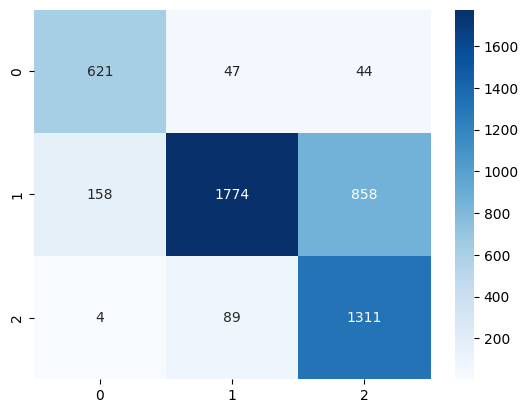

In [19]:
nl_bert_name = 'GroNLP/bert-base-dutch-cased'
nl_tokenizer = AutoTokenizer.from_pretrained(nl_bert_name)
nl_tokenized_datasets = raw_datasets.map(lambda x: tokenize_function(nl_tokenizer, x), batched=True)
nl_data_collator = DataCollatorWithPadding(tokenizer=nl_tokenizer)
nl_model = AutoModelForSequenceClassification.from_pretrained(nl_bert_name, num_labels=3)
nl_training_args = TrainingArguments(
    "my-trainer-nl",
    per_device_train_batch_size=16,
    num_train_epochs=3,
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    dataloader_num_workers=0,
    load_best_model_at_end=True,
    save_total_limit=2
)

nl_trainer = Trainer(
    nl_model,
    nl_training_args,
    train_dataset=nl_tokenized_datasets['train'],
    eval_dataset=nl_tokenized_datasets['validation'],
    data_collator=nl_data_collator,
    tokenizer=nl_tokenizer,
    compute_metrics=compute_metrics
)

nl_trainer.train()
nl_test_predictions = nl_trainer.predict(nl_tokenized_datasets['test'])
print('Dutch Test accuracy: ', nl_test_predictions.metrics['test_accuracy'])
nl_preds = np.argmax(nl_test_predictions.predictions, axis=1)
nl_trues = nl_test_predictions.label_ids

nl_cf_matrix = confusion_matrix(nl_trues, nl_preds)
display(nl_cf_matrix)

sns.heatmap(nl_cf_matrix, annot=True, cmap='Blues', fmt='g')

nl_precision, nl_recall, nl_f1, nl_support = precision_recall_fscore_support(nl_trues, nl_preds)
display(nl_precision)
display(nl_recall)
display(nl_f1)
display(nl_support)


### Part 3.2 (12 points)
Now we wish to quantify the difference between the Dutch and English model results. Execute the following:

1. Gather those predictions and true labels for which the English and Dutch model disagree, quantifying the percentage of cases where they disagree.
2. Then, calculate and display the English confusion matrix, and Dutch confusion matrix for these cases.
3. Then report on your findings. For example, when the models disagree, does the English model have a stronger tendency to classify sentence pairs as Neutral?

*Note: the heatmap plots are in separate cells to avoid Seaborn to plot them on top of each other :)*

Number of disagreement cases: 1165
Percentage of disagreement cases: 23.75%


<Axes: >

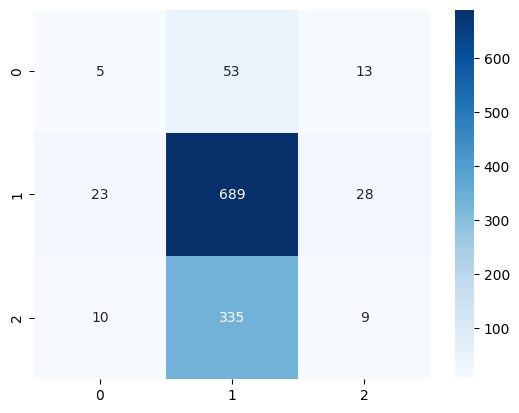

In [21]:
disagreement_mask = preds != nl_preds

dis_trues = trues[disagreement_mask]
dis_en_preds = preds[disagreement_mask]
dis_nl_preds = nl_preds[disagreement_mask]

disagree_count = np.sum(disagreement_mask)
total_count = len(trues)
disagree_percentage = (disagree_count / total_count) * 100

print(f"Number of disagreement cases: {disagree_count}")
print(f"Percentage of disagreement cases: {disagree_percentage:.2f}%")

dis_en_cf_matrix = confusion_matrix(dis_trues, dis_en_preds)
dis_nl_cf_matrix = confusion_matrix(dis_trues, dis_nl_preds)
sns.heatmap(dis_en_cf_matrix, annot=True, cmap='Blues', fmt='g')

<Axes: >

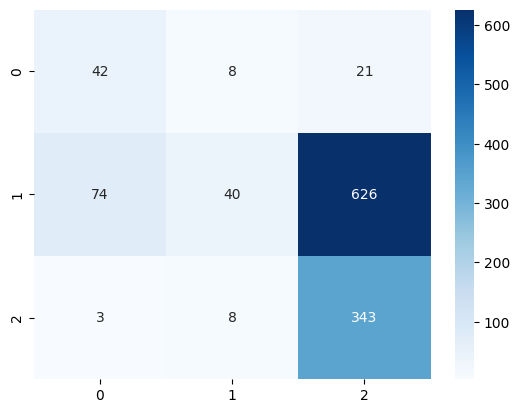

In [22]:
sns.heatmap(dis_nl_cf_matrix, annot=True, cmap='Blues', fmt='g')

#### Explanation

Judjing by the disagreement cases, we see how the English and Dutch models handle challenging examples. When the two models disagree, the English model often "plays it safe" by predicting Neutral and struggles to confidently identify Contradiction or Entailment. The Dutch model, on the other hand, is better at picking Entailment but also tends to misinterpret Neutral sentences as Entailment.



## Part 4 (32 points): In-context learning

Okay, while it's great that we can reach high accuracy with low effort by using built-in functionality from HuggingFace, let's try and see if we can do without fine-tuning at all, and use *in-context learning* with a generative model on the exact same task.

Recall that for in-context learning, we take a large pretrained generative model (like GPT-3) and pose it with a prompt that specifies our task format and then we hope it generates text for a new case that corresponds to the correct answer! In this way we can do classification as well.

Now for the bad news: OpenAI never officially released their GPT-3+ models, so we will do with the last available version, GPT-2*. No worries though: since this model is so much smaller we can actually use it on our own machines ;-) in the end, you just need to change the model's name to try out a larger model as soon as you get your hands on a powerful enough computing device.

Let's start with setting up the GPT-2 model in the right setting: text generation. We will make use of HuggingFace's built-in `pipeline` for this. Start by running the below code that sets up the generative model in text generation mode.

**In fact, the version of GPT-2 we'll be using is not even the largest GPT-2 model around. But hey, you get the general idea right? Just swapping a model's name will allow us to perform the exact same task, just with a larger model.*

In [23]:
from transformers import pipeline, AutoTokenizer
import torch

torch.manual_seed(0)
model = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    pad_token_id=tokenizer.eos_token_id)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cpu


Now let's see how generation works with some starting prompt. Note that we're setting a seed to guarantee that the model will give the same output.

In [24]:
from transformers import set_seed
set_seed(5287935)

prompt = "My incomplete sentence is"
sequences_full = pipe(prompt, max_new_tokens=15, return_full_text=True)
sequences_generated = pipe(prompt, max_new_tokens=15, return_full_text=False)
print(sequences_full[0]['generated_text'])
print('\n\n')
print(sequences_generated[0]['generated_text'])

My incomplete sentence is an example of how your mind is to go: the best thing I do



 the worst: "You can kill us, but not after taking full responsibility


Okay, let's try a serious NLI prompt. We will try a few-shot setting in which the model will have seen one example for each NLI label. The code below grabs one example for each label from the validation data, and places them in a prompt, which contains a test pair (Does "This is difficult." entail "This is easy."?). Then, we ask the model to generate the next few tokens to see if it gives some sensible prediction.

In [25]:
co_example = raw_datasets['validation'][0]
co_example_sentence_a = co_example['sentence_A_original']
co_example_sentence_b = co_example['sentence_B_original']

ne_example = raw_datasets['validation'][1]
ne_example_sentence_a = ne_example['sentence_A_original']
ne_example_sentence_b = ne_example['sentence_B_original']

en_example = raw_datasets['validation'][7]
en_example_sentence_a = en_example['sentence_A_original']
en_example_sentence_b = en_example['sentence_B_original']

prompt = f"For Sentence A and Sentence B, classify as Entailment, Neutral, or Contradiction.\n\
Sentence A: {co_example_sentence_a}\nSentence B: {co_example_sentence_b}\nNLI Label: Contradiction.\n\
Sentence A: {ne_example_sentence_a}\nSentence B: {ne_example_sentence_b}\nNLI Label: Neutral.\n\
Sentence A: {en_example_sentence_a}\nSentence B: {en_example_sentence_b}\nNLI Label: Entailment.\n\
Sentence A: This is difficult.\nSentence B: This is easy.\n NLI Label:"

prompting_examples = pipe(prompt, max_new_tokens=3, return_full_text=False)
print(prompting_examples[0]['generated_text'])

 Contradiction


Pretty cool, right? Is the answer correct?

If we want to systematically assess how well the model does on the full dataset, we will need a few ingredients, and these are the steps you will follow:

1. A way to encode each sentence pair as a prompt.
2. A loop to run the model on all of the prompts.
3. Functionality to decode the model's output back to an NLI label.

### Part 4.1 (10 points)

First off, implement the function `create_prompt` below, that returns an NLI prompt but with the two given sentences (A and B). Verify with the code underneath to see what happens.

*Hint: you can re-use the prompt above in your solution.*

In [28]:
def create_prompt(sentence_a, sentence_b):
    prompt = (
        "For Sentence A and Sentence B, classify as Entailment, Neutral, or Contradiction.\n"
        f"Sentence A: {co_example_sentence_a}\nSentence B: {co_example_sentence_b}\nNLI Label: Contradiction.\n"
        f"Sentence A: {ne_example_sentence_a}\nSentence B: {ne_example_sentence_b}\nNLI Label: Neutral.\n"
        f"Sentence A: {en_example_sentence_a}\nSentence B: {en_example_sentence_b}\nNLI Label: Entailment.\n"
        f"Sentence A: {sentence_a}\nSentence B: {sentence_b}\nNLI Label:"
    )
    return prompt


In [29]:
ex = raw_datasets['test'][0]
prompt = create_prompt(ex['sentence_A_original'], ex['sentence_B_original'])
print(prompt)
sequences = pipe(prompt, max_new_tokens=3, return_full_text=False)
display(sequences)

For Sentence A and Sentence B, classify as Entailment, Neutral, or Contradiction.
Sentence A: The young boys are playing outdoors and the man is smiling nearby
Sentence B: There is no boy playing outdoors and there is no man smiling
NLI Label: Contradiction.
Sentence A: A person in a black jacket is doing tricks on a motorbike
Sentence B: A skilled person is riding a bicycle on one wheel
NLI Label: Neutral.
Sentence A: Two dogs are playing by a tree
Sentence B: Two dogs are playing by a plant
NLI Label: Entailment.
Sentence A: There is no boy playing outdoors and there is no man smiling
Sentence B: A group of kids is playing in a yard and an old man is standing in the background
NLI Label:


[{'generated_text': ' Contradiction'}]

### Part 4.2 (10 points)

You may notice that the output is not exactly clean, and it could even be a completely different text than an NLI label! So you'll need to finish the function `decode_prompting_result` below, that will take the output of the generation and return an actual label. Note that the function should return the correct label if the output corresponds to an NLI label, and a fourth label in case the output is something different.

In [35]:
def decode_prompting_result(result: str) -> int:
    result_label = result.lower().strip()
    label2int_lower = {k.lower(): v for k, v in label2id.items()}

    if result_label in label2int_lower:
        return label2int_lower[result_label]
    else:
        return 3 #3 indicates unknown

print(decode_prompting_result("Entailment"))   # should return 2
print(decode_prompting_result("neutral"))       # should return 1
print(decode_prompting_result("Contradiction")) # should return 0
print(decode_prompting_result("Nonsense"))      # should return 3


2
1
0
3


### Part 4.3 (5 points)

Now to actually run the whole thing: for each item in the test data we want to create a prompt, feed it to the model, and transform the result into a label. We want to end up with a list of predictions, just like with the finetuned models before. The only difference will be that we have a fourth possible label. Run the below code as is (don't forget to make tea while you wait!), and run the code underneath to see a sample of the predictions.

In [36]:
from tqdm import tqdm

generation_preds = []
for d in tqdm(raw_datasets['test']):
    prompt = create_prompt(d['sentence_A_original'], d['sentence_B_original'])
    results = pipe(prompt, max_new_tokens=3, return_full_text=False)
    label = decode_prompting_result(results[0]['generated_text'])
    generation_preds.append(label)

100%|██████████| 4906/4906 [1:35:16<00:00,  1.17s/it]


In [41]:
print(generation_preds[:50])

[3, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 3, 0, 3, 3, 0, 3, 3, 0, 0, 2, 0, 3, 0, 3, 0, 0, 3, 3, 3, 0, 0, 0, 3, 3, 0, 3, 3, 3, 0, 0, 0, 3, 3, 0, 0, 0]


### Part 4.4 (7 points)

As a last step, do what you do best and display the confusion matrix, precision, recall and F1 score for the prompting setup.

Class: Contradiction
  Precision: 0.15
  Recall:    0.73
  F1 Score:  0.24
Class: Neutral
  Precision: 0.00
  Recall:    0.00
  F1 Score:  0.00
Class: Entailment
  Precision: 0.27
  Recall:    0.01
  F1 Score:  0.03
Class: Other
  Precision: 0.00
  Recall:    0.00
  F1 Score:  0.00

Macro-average metrics:
  Precision: 0.10
  Recall:    0.19
  F1 Score:  0.07


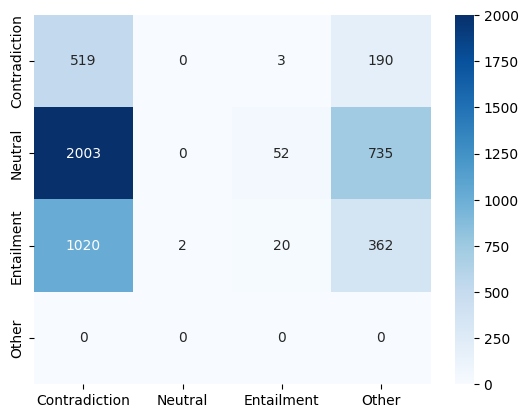

In [40]:
true_labels = [d['label'] for d in raw_datasets['test']]
extended_id2label = {0: 'Contradiction', 1: 'Neutral', 2: 'Entailment', 3: 'Other'}

conf_matrix = confusion_matrix(true_labels, generation_preds, labels=[0,1,2,3])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(extended_id2label.values()),
            yticklabels=list(extended_id2label.values()))


precision, recall, f1, _ = precision_recall_fscore_support(true_labels, generation_preds, labels=[0,1,2,3], zero_division=0)
for idx, lbl in extended_id2label.items():
    print(f"Class: {lbl}")
    print(f"  Precision: {precision[idx]:.2f}")
    print(f"  Recall:    {recall[idx]:.2f}")
    print(f"  F1 Score:  {f1[idx]:.2f}")

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(true_labels, generation_preds, average='macro', zero_division=0)
print("\nMacro-average metrics:")
print(f"  Precision: {precision_macro:.2f}")
print(f"  Recall:    {recall_macro:.2f}")
print(f"  F1 Score:  {f1_macro:.2f}")

### Bonus Exercise: Decoding strategies

If you are unsatisfied with the result, you may be happy to know that you can apply the decoding strategies you saw in the lecture (such as beam search, top-k sampling, top-p nucleus sampling) also in the current context, by adding the same arguments to the `pipe` when you run it on a prompt. You will get bonus points for trying out at least two different generation strategies and seeing how this affects the result.

### Alternative Bonus Exercise: Seed-averaging

You may notice that text generation can be different on the same prompt each time that you run the model. You can score bonus points by running the model over the dataset three times and aggregating the results in a way you choose.